In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression
from sklearn.base import clone
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import math

In [3]:
from sensitivity import dml_sensitivity_bounds, dml_tvalue, dml_estimate
from sensitivity import sensitivity_bounds, tvalue, sensitivity_contours, moment_estimate
from rfriesz import RFreg, RFrr, poly_feature_fns
from sievereisz import SieveRR, SparseSieveRR, Featurizer
from debiased import DebiasedMoment
from econml.dml import LinearDML

In [4]:
from automl import reg_fn_gen, rr_fn_gen, model_y_fn_gen, model_t_fn_gen

In [5]:
# The moment function, whose average we want to estimate: E[m(X; g)]
def moment_fn(x, test_fn):
    t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
    t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0)

In [6]:
# Data loading and manipulation

# for semi-synthetic data generation
def true_f(X):
    y = (-.7 - .4 * scipy.special.expit(3 * (1 - 2*(X[:, 1] - 10.5)))) * X[:, 0]
    y += scipy.special.expit(3 * (1 - 2 * (X[:, 1] > 11.5)))
    return y

# def true_f(X):
#     y = -.7 * X[:, 0]
#     y += scipy.special.expit(3 * (1 - 2 * (X[:, 1] > 11.5)))
#     return y

def get_data(q=1, synthetic=False, random_seed=123):
    dfx = pd.read_csv('./401k/401k-x.csv', sep=',')
    dfy = pd.read_csv('./401k/401k-y.csv', sep=',')
    dfd = pd.read_csv('./401k/401k-d.csv', sep=',')
    dfx = dfx.drop(['db'], axis=1) # highly predictable from income
    X = np.hstack([dfd.values, dfx.values])
    column_names = ['treatment'] + list(dfx.columns)
    y = dfy.values.flatten() # outcome to numpy array
    if synthetic: # impute synthetic outcome based on known relationship
        y = true_f(X) + np.random.normal(0, .2, size=X[:, 0].shape)
        print(np.mean(moment_fn(X, true_f)))
    
    # Create state-block-wise and stratified by region folds for cross validation and cross fitting
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    splits = list(cv.split(X, X[:, 0]))
    return X, y, [1, 2, 3, 4], splits, column_names

In [7]:
# global result dictionaries and global parameters
ests = {}
res = {}
res_d = {}
synthetic = False # use synthetic outcome
q_grid = np.arange(1, 2) # this is not really used but only for code uniformity
verbose = 0

# Ablation study for riesz variance explained

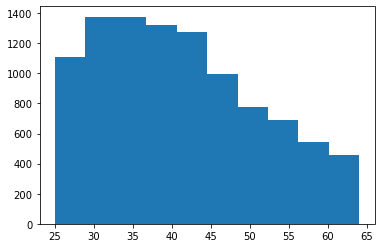

In [8]:
# log-income distribution
X, y, num_cols, splits, column_names = get_data(random_seed=124)
plt.hist(X[:, 1])
plt.show()

In [9]:
print(column_names)

['treatment', 'age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'pira', 'hown']


In [10]:
ablation_groups = list([(n, [c]) for n, c in zip(column_names[1:], np.arange(1, len(column_names)))])
ablation_groups

[('age', [1]),
 ('inc', [2]),
 ('educ', [3]),
 ('fsize', [4]),
 ('marr', [5]),
 ('twoearn', [6]),
 ('pira', [7]),
 ('hown', [8])]

In [11]:
from ablation import ablation_multiseed, plr_ablation_multiseed
get_data_fn = lambda seed: get_data(random_seed=seed)

In [17]:
plr_etasq, plr_Cy, plr_dtheta, plr_rho = plr_ablation_multiseed(ablation_groups, moment_fn,
                                                                get_data_fn, model_y_fn_gen, model_t_fn_gen, verbose)

In [18]:
for key, value in plr_etasq.items():
    print(key, f'etasq={value[0]:.4f} ({value[1]:.4f}), Cy={plr_Cy[key][0]:.4f} ({plr_Cy[key][1]:.4f}), ',
          f'dtheta={plr_dtheta[key][0]:.4f} ({plr_dtheta[key][1]:.4f}), ',
          f'rho={plr_rho[key][0]:.4f} ({plr_rho[key][1]:.4f})')

age etasq=0.0015 (0.0013), Cy=0.0791 (0.0211),  dtheta=-476.7143 (346.7868),  rho=-0.3856 (0.3002)
inc etasq=0.0532 (0.0055), Cy=0.1466 (0.0311),  dtheta=4196.5607 (609.6360),  rho=0.3711 (0.0580)
educ etasq=0.0009 (0.0006), Cy=-0.0055 (0.0032),  dtheta=58.9738 (68.2037),  rho=942989.3167 (4379270121212497408.0000)
fsize etasq=-0.0003 (0.0004), Cy=-0.0014 (0.0025),  dtheta=78.1259 (86.0589),  rho=78125920.6296 (267965841635561996288.0000)
marr etasq=0.0006 (0.0005), Cy=0.0030 (0.0032),  dtheta=-132.1003 (73.9546),  rho=-0.7734 (0.6926)
twoearn etasq=0.0003 (0.0003), Cy=0.0330 (0.0131),  dtheta=-1003.3295 (249.6944),  rho=-2.6816 (1.1521)
pira etasq=0.0003 (0.0003), Cy=0.0493 (0.0103),  dtheta=461.0659 (298.5754),  rho=0.9180 (0.6324)
hown etasq=0.0044 (0.0013), Cy=0.0026 (0.0015),  dtheta=531.9980 (118.9456),  rho=1.3311 (0.3469)


In [19]:
np_etasq, np_Cy, np_dtheta, np_rho = ablation_multiseed(ablation_groups, moment_fn,
                                                        get_data_fn, reg_fn_gen, rr_fn_gen, verbose)

In [20]:
for key, value in np_etasq.items():
    print(key, f'etasq={value[0]:.4f} ({value[1]:.4f}), Cy={np_Cy[key][0]:.4f} ({np_Cy[key][1]:.4f}), ',
          f'dtheta={np_dtheta[key][0]:.4f} ({np_dtheta[key][1]:.4f}), ',
          f'rho={np_rho[key][0]:.4f} ({np_rho[key][1]:.4f})')

age etasq=-0.0035 (0.0083), Cy=0.0122 (0.0094),  dtheta=-595.7798 (201.0314),  rho=-77.7459 (1513027.0471)
inc etasq=0.1408 (0.0192), Cy=0.1166 (0.0306),  dtheta=4216.8946 (573.3677),  rho=0.2438 (0.0443)
educ etasq=0.0063 (0.0070), Cy=0.0003 (0.0022),  dtheta=10.1323 (76.7265),  rho=0.0342 (4.5692)
fsize etasq=-0.0025 (0.0021), Cy=-0.0004 (0.0020),  dtheta=-18.6490 (58.6627),  rho=-19.7522 (316952561172009088.0000)
marr etasq=0.0002 (0.0013), Cy=-0.0001 (0.0009),  dtheta=17.6450 (35.8924),  rho=915303.1446 (388626584975433216.0000)
twoearn etasq=0.0002 (0.0004), Cy=0.0127 (0.0055),  dtheta=-204.8095 (92.9161),  rho=-1.6417 (1.3084)
pira etasq=0.0002 (0.0005), Cy=0.0476 (0.0149),  dtheta=483.8286 (371.1779),  rho=0.3716 (0.7004)
hown etasq=0.0019 (0.0036), Cy=0.0005 (0.0004),  dtheta=338.3333 (86.5775),  rho=2.6201 (5.8876)


# Main Analysis

In [16]:
# General pipeline for all types of estimators to generate the estimation result we want
def generic_pipeline(estimator, q_grid, name, n_seeds=5):
    ests = {}
    res = {}
    for q in q_grid:
        print(f'q={q}')
        ests[f'q={q}'] = []
        estimate_list = []
        for random_seed in np.arange(123, 123 + n_seeds):
            X, y, num_cols, splits, _ = get_data(q, synthetic=synthetic, random_seed=random_seed)
            estimates, model = estimator(X, y, num_cols, splits)
            print(estimates)
            estimate_list.append(estimates)
            ests[f'q={q}'].append(model)
        estimate_list = np.array(estimate_list)
        res[f'q={q}'] = {}
        res[f'q={q}'][f'{name}'] = {}
        res[f'q={q}'][f'{name}']['point'] = np.mean(estimate_list[:, 0])
        if estimate_list.shape[1] > 2:
            res[f'q={q}'][f'{name}']['stderr'] = np.sqrt(np.mean(estimate_list[:, 1]**2) 
                                                         + np.var(estimate_list[:, 0]))
        res[f'q={q}'] = pd.DataFrame(res[f'q={q}']).transpose()
    return pd.concat(res), ests

In [17]:
# Transforming results to a nicely printable dataframe where each cell
# contains point (stderr) [ci_lower, ci_upper]
def transform_res_to_df(res, q_grid, alpha=None):
    res_f = res.reset_index()
    res_d = {}
    for q in q_grid:
        key = 'all <= 11.6' if q==0 else ('all' if q==5 else f'q={q}')
        res_d[key] = {}
        for method in np.unique(res_f['level_1'].values):
            p = res.loc[(f'q={q}', method), 'point']
            if alpha is not None:
                s = res.loc[(f'q={q}', method), 'stderr']
                error = scipy.stats.norm.ppf(1 - alpha) * s
                l, u = p - error, p + error
                res_d[key][method] = f"{p:.2f} ({s:.2f}) [{l:.2f}, {u:.2f}]"
            else:
                res_d[key][method] = f"{p:.2f}"
        
    return pd.DataFrame(res_d)

In [18]:
if synthetic:
    def oracle_estimator(X, y, num_cols, splits):
        return (np.mean(moment_fn(X, true_f)),), None
    res['true'], _ = generic_pipeline(oracle_estimator, q_grid, 'true', n_seeds=1)
    res_d['true'] = transform_res_to_df(res['true'], q_grid)
    display(res_d['true'])

# Non-Linear RR Analysis

In [19]:
# fully non-parametric average derivative estimation
def nonlinrr(X, y, num_cols, splits):
    get_reisz_fn = rr_fn_gen(moment_fn, num_cols, cv=splits, verbose=verbose)
    get_reg_fn = reg_fn_gen(num_cols, cv=splits, verbose=verbose)
    est = DebiasedMoment(moment_fn=moment_fn,
                         get_reisz_fn=get_reisz_fn,
                         get_reg_fn=get_reg_fn,
                         n_splits=splits)
    est.fit(X, y)
    return est.avg_moment(alpha=.1), est

In [20]:
res['rr'], ests['rr'] = generic_pipeline(nonlinrr, q_grid, 'dr')

q=1
(7565.487318876264, 1165.6447142614813, 5647.993207937338, 9482.981429815189)
(7577.424854628451, 1164.4918539991254, 5661.827207283241, 9493.02250197366)
(7574.716607841946, 1163.1910188260308, 5661.2588439047695, 9488.174371779121)
(7569.597137556487, 1138.3321205689303, 5697.0324437196805, 9442.161831393294)
(7586.085474416687, 1161.9540426058695, 5674.662545441237, 9497.508403392138)


In [21]:
res_d['rr'] = transform_res_to_df(res['rr'], q_grid, alpha=0.05)
res_d['rr']

,q=1
dr,"7574.66 (1158.79) [5668.62, 9480.70]"


# OLS analysis

In [22]:
# fully linear OLS-based average derivative estimation
def ols_estimator(X, y, num_cols, splits):
    est = OLS(y, np.hstack([np.ones((X.shape[0], 1)), X])).fit(cov_type='HC3')
    return (est.params[1], est.bse[1], *est.conf_int(alpha=.1)[1]), est

In [23]:
res['ols'], ests['ols'] = generic_pipeline(ols_estimator, q_grid, 'ols', n_seeds=1)

q=1
(4949.022797540579, 1578.5857095118429, 2352.480367796261, 7545.5652272848965)


In [24]:
res_d['ols'] = transform_res_to_df(res['ols'], q_grid, alpha=0.05)
res_d['ols']

,q=1
ols,"4949.02 (1578.59) [2352.48, 7545.57]"


# Lasso Analysis

In [25]:
# fully linear Lasso-based average derivative estimation
def lasso_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    est = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                    ('lasso', LassoCV(cv=splits))])
    est.fit(X, y)
    p = np.mean(est.predict(np.hstack([np.ones((X.shape[0], 1)), X[:, 1:]])) 
            - est.predict(np.hstack([np.zeros((X.shape[0], 1)), X[:, 1:]])))
    return (p,), est

In [26]:
res['lasso'], ests['lasso'] = generic_pipeline(lasso_estimator, q_grid, 'lasso')

q=1
(4840.142607250498,)
(4840.142607250498,)
(4840.142607250498,)
(4840.142607250498,)
(4840.142607250498,)


In [27]:
res_d['lasso'] = transform_res_to_df(res['lasso'], q_grid)
res_d['lasso']

,q=1
lasso,4840.14


# DML Analysis

In [28]:
# fully linear debiased Lasso-based average derivative estimation, with doubleML
def dml_lasso_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    model_reg = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                          ('lasso', LassoCV(cv=splits))])
    model_y = clone(model_reg).fit(X[:, 1:], y)
    model_y = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                        ('lasso', Lasso(alpha=model_y.named_steps['lasso'].alpha_))])
    model_t = clone(model_reg).fit(X[:, 1:], X[:, 0])
    model_t = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                        ('lasso', Lasso(alpha=model_t.named_steps['lasso'].alpha_))])
    est = LinearDML(model_y=model_y,
                    model_t=model_t,
                    linear_first_stages=False,
                    cv=splits, random_state=123)
    est.fit(y, X[:, 0], W=X[:, 1:], cache_values=True)
    p = est.intercept__inference().point_estimate
    s = est.intercept__inference().stderr
    l, u = est.intercept__inference().conf_int(alpha=.1)
    return (p, s, l, u), est

In [29]:
res['dml_lasso'], ests['dml_lasso'] = generic_pipeline(dml_lasso_estimator, q_grid, 'dml_lasso')

q=1
(5004.938364070149, 1568.315644126422, 2425.288688624068, 7584.5880395162285)
(4961.457180568416, 1569.691991669472, 2379.543614874204, 7543.370746262627)
(4978.097578254555, 1571.4274925909892, 2393.3293675750074, 7562.865788934101)
(4923.580256329652, 1581.9249447358293, 2321.545273415915, 7525.615239243388)
(4900.439152220281, 1589.8040066707115, 2285.444265705978, 7515.434038734584)


In [30]:
res_d['dml_lasso'] = transform_res_to_df(res['dml_lasso'], q_grid, alpha=.05)
res_d['dml_lasso']

,q=1
dml_lasso,"4953.70 (1576.70) [2360.26, 7547.14]"


# DML with Non-Linear Residualizers

In [31]:
# partially linear average derivative estimation, with doubleML
def dml_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    model_y = model_y_fn_gen(num_cols, cv=splits, verbose=verbose)(X[:, 1:], y)
    model_t = model_t_fn_gen(num_cols, cv=splits, verbose=verbose)(X[:, 1:], X[:, 0])
    est = LinearDML(model_y=model_y(),
                    model_t=model_t(),
                    linear_first_stages=False,
                    cv=splits, random_state=123)
    est.fit(y, X[:, 0], W=X[:, 1:], cache_values=True)
    p = est.intercept__inference().point_estimate
    s = est.intercept__inference().stderr
    l, u = est.intercept__inference().conf_int(alpha=.1)
    return (p, s, l, u), est

In [32]:
res['dml'], ests['dml'] = generic_pipeline(dml_estimator, q_grid, 'dml')

q=1
(8291.40622694514, 1293.2107535426014, 6164.263828567946, 10418.548625322335)
(8228.393945038677, 1304.1418206582673, 6083.271541269829, 10373.516348807525)
(8136.42995599257, 1297.0574582663191, 6002.960291398756, 10269.899620586384)
(8198.527214705944, 1311.9747987325238, 6040.520708541824, 10356.533720870064)
(8214.624735615622, 1288.9219409021512, 6094.536806265387, 10334.712664965857)


In [33]:
res_d['dml'] = transform_res_to_df(res['dml'], q_grid, alpha=.05)
res_d['dml']

,q=1
dml,"8213.88 (1300.05) [6075.49, 10352.26]"


# Put all results together

In [34]:
res_d_all = pd.concat(res_d)

In [35]:
heading_properties = [('font-size', '11px')]

cell_properties = [('font-size', '11px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

res_d_all.style.set_table_styles(dfstyle)

,,q=1
rr,dr,"7574.66 (1158.79) [5668.62, 9480.70]"
ols,ols,"4949.02 (1578.59) [2352.48, 7545.57]"
lasso,lasso,4840.14
dml_lasso,dml_lasso,"4953.70 (1576.70) [2360.26, 7547.14]"
dml,dml,"8213.88 (1300.05) [6075.49, 10352.26]"


# Paper tables

In [36]:
table = {}
table['point'] = '{:.3f} ({:.3f})'.format(res['rr'].loc[(f'q={1}', 'dr'), 'point'],
                                          res['rr'].loc[(f'q={1}', 'dr'), 'stderr'])

est_list = ests['rr'][f'q={1}']
table['Bounds'] = '[{:.3f}, {:.3f}]'.format(*sensitivity_bounds(est_list, .04, .03, alpha=None))
table['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*sensitivity_bounds(est_list, .04, .03, alpha=.05))
table['RV(v=0)'] = '{:.3f}'.format(tvalue(est_list, value=0, leq=True, alpha=None))
table['RV(v=0,a=.05)'] = '{:.3f}'.format(tvalue(est_list, value=0, leq=True, alpha=.05))

In [37]:
table2 = {}
table2['point'] = '{:.3f} ({:.3f})'.format(res['dml_lasso'].loc[(f'q={1}', 'dml_lasso'), 'point'],
                                          res['dml_lasso'].loc[(f'q={1}', 'dml_lasso'), 'stderr'])

est_list = ests['dml_lasso'][f'q={1}']
table2['Bounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .04, .03, alpha=None))
table2['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .04, .03, alpha=.05))
table2['RV(v=0)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=True, alpha=None))
table2['RV(v=0,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=True, alpha=.05))

In [38]:
table2 = {}
table2['point'] = '{:.3f} ({:.3f})'.format(res['dml'].loc[(f'q={1}', 'dml'), 'point'],
                                          res['dml'].loc[(f'q={1}', 'dml'), 'stderr'])

est_list = ests['dml'][f'q={1}']
table2['Bounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .04, .03, alpha=None))
table2['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .04, .03, alpha=.05))
table2['RV(v=0)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=True, alpha=None))
table2['RV(v=0,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=True, alpha=.05))

In [39]:
tabledf = pd.DataFrame({'Non-parametric': table, 'Partially linear': table2}).T[['point', 'Bounds', 'CIBounds',
                                                                                 'RV(v=0)', 'RV(v=0,a=.05)']]
tabledf

,point,Bounds,CIBounds,RV(v=0),"RV(v=0,a=.05)"
Non-parametric,7574.662 (1158.790),"[3039.423, 12109.901]","[1023.832, 14066.046]",0.057,0.042
Partially linear,8213.876 (1300.045),"[4029.129, 12398.624]","[1812.221, 14576.346]",0.067,0.049


In [40]:
print(tabledf.to_latex())

\begin{tabular}{llllll}
\toprule
{} &                point &                 Bounds &               CIBounds & RV(v=0) & RV(v=0,a=.05) \\
\midrule
Non-parametric   &  7574.662 (1158.790) &  [3039.423, 12109.901] &  [1023.832, 14066.046] &   0.057 &         0.042 \\
Partially linear &  8213.876 (1300.045) &  [4029.129, 12398.624] &  [1812.221, 14576.346] &   0.067 &         0.049 \\
\bottomrule
\end{tabular}



# Analysis by income

In [41]:
def plot_by_income(nq, method, dml):
    if dml:
        sens_fn, est_fn = dml_sensitivity_bounds, dml_estimate
    else:
        sens_fn, est_fn = sensitivity_bounds, moment_estimate
    X, _, _, _, _ = get_data(1, synthetic=synthetic, random_seed=123)
    inds = np.argsort(X[:, 2])
    splits = np.array_split(inds, nq)
    point = np.zeros(nq)
    stderr = np.zeros(nq)
    bounds = np.zeros((nq, 2))
    cibounds = np.zeros((nq, 2))
    qgr = np.arange(nq)
    for q in qgr:
        points, stderrs = zip(*[est_fn(est, inds=splits[q]) for est in ests[method]['q=1']])
        points, stderrs = np.array(points), np.array(stderrs)
        point[q] = np.mean(points)
        stderr[q] = np.sqrt(np.mean(stderrs**2) + np.var(points))
        bounds[q, :] = sens_fn(ests[method]['q=1'], .04, .03, inds=splits[q])
        cibounds[q, :] = sens_fn(ests[method]['q=1'], .04, .03, alpha=0.05, inds=splits[q])
        
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.fill_between(qgr, point - 1.645*stderr, point + 1.645*stderr, alpha=.4)
    plt.plot(qgr, point)
    plt.xlabel("Income groups by quartiles")
    plt.ylabel("ATE")

    plt.subplot(1, 2, 2)
    plt.fill_between(qgr, cibounds[:, 0], cibounds[:, 1], alpha=.4)
    plt.fill_between(qgr, bounds[:, 0], bounds[:, 1], alpha=.4)
    plt.plot(qgr, point)
    plt.xlabel("Income groups by quartiles")
    plt.ylabel("ATE")
    plt.tight_layout()
    plt.show()

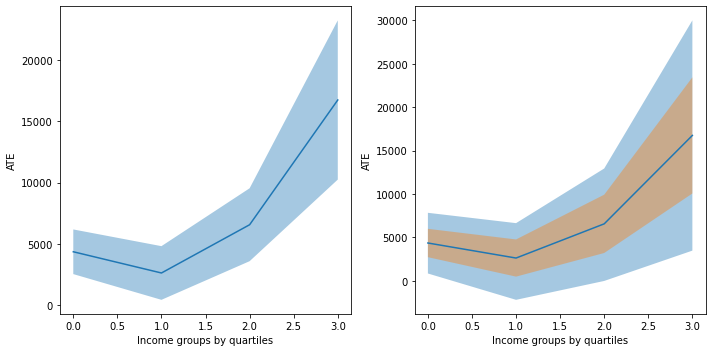

In [42]:
plot_by_income(4, 'rr', False)

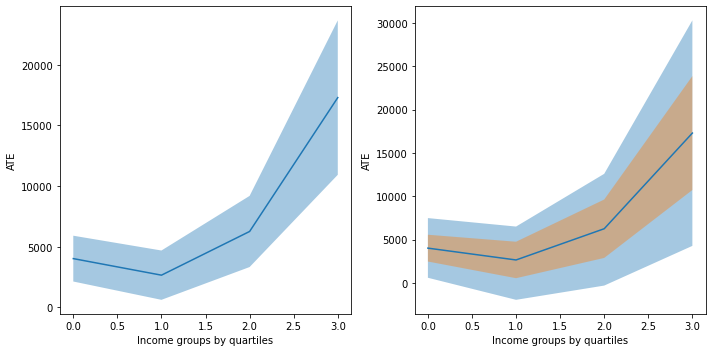

In [43]:
plot_by_income(4, 'dml', True)

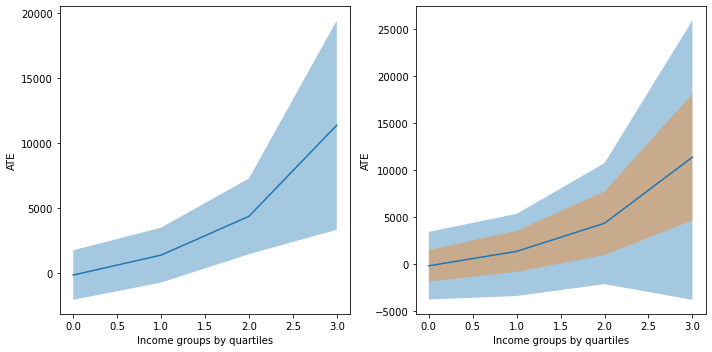

In [44]:
plot_by_income(4, 'dml_lasso', True)